Here I do a bit of feature engineering and create the final model. Afterwards, I show how the model would predict the BABIPs of the players with the highest and lowest actual BABIPs of 2019 to illustrate how it could be used for outlier detection to see what players got 'lucky' or 'unlucky'.

In [3]:
from pyforest import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import scipy.stats as stats

In [4]:
df = pd.read_csv('../data/trimmeddf.csv')

# Feature Engineering

In [5]:
#these three features were the most valuable as determined by cross validation in earlier model iterations
#Coors is simply whether or not a player was a member of the Rockies in a given season
#Pull/OppoRatio is a shorthand for how pull-heavy and therefore shiftable a player was
#Shift%*GB is a means of weighting how much a player was shifted by their groundball rate

df['Coors'] = pd.get_dummies(df.Team,drop_first=True)['Rockies']
df['Pull/OppoRatio'] = df.Pull/df.Oppo
df['Shift%*GB'] = df['Shift%']*df['GB']

In [6]:
df.fillna(df.mean(),inplace=True)

# Modeling

In [7]:
#grabbing features most important as determined by prior cross validation
X = df[['ISO','LD','GB','IFFB','IFH','SweetSpot%','Above95MPH%','FBLDAvgEV','Age','Shift%','Coors','Pull/OppoRatio','Shift%*GB']]
y = df.Babip

In [8]:
def split_and_cv_lin(X,y):
    
    '''trains and cross validates linear model'''
    
    X,X_test,y,y_test = train_test_split(X,y,test_size=.2,random_state=42)
    X,y = np.array(X),np.array(y)
    
    train_r2s = []
    cv_lm_r2s = []
    lm_MAEs = []

    kf = KFold(n_splits=5,shuffle=True,random_state=43)
    
    for train_ind, val_ind in kf.split(X,y):
        
        X_train,y_train = X[train_ind],y[train_ind]
        X_val,y_val = X[val_ind],y[val_ind]
        
        lm = LinearRegression()
        lm.fit(X_train,y_train)
        cv_lm_r2s.append(lm.score(X_val,y_val))
        preds = lm.predict(X_train)
        lm_MAEs.append(np.mean(np.abs(preds-y_train)))
        train_r2s.append(lm.score(X_train,y_train))
    
    print(f'Lin Train R^2s: {train_r2s}')
    print(f'Lin Mean Train R^2: {np.mean(train_r2s)} +- {np.std(train_r2s)}')
    print(f'Lin CV R^2s: {cv_lm_r2s}')
    print(f'Lin CV Mean R^2: {np.mean(cv_lm_r2s)} +- {np.std(cv_lm_r2s)}')
    print(f'Lin MAEs: {lm_MAEs} \nMean MAE: {np.mean(lm_MAEs)}')
    print(list(zip(X_test.columns,lm.coef_)))

In [9]:
def split_and_cv_lasso(X,y,alph):
    
    '''Trains and cross validates linear model with lasso regularization'''
    
    X,X_test,y,y_test = train_test_split(X,y,test_size=.2,random_state=42)
    X,y = np.array(X),np.array(y)
    
    cv_lasso_r2s = []
    lasso_MAEs = []

    kf = KFold(n_splits=5,shuffle=True,random_state=43)
    
    for train_ind, val_ind in kf.split(X,y):
        
        X_train,y_train = X[train_ind],y[train_ind]
        X_val,y_val = X[val_ind],y[val_ind]
        
        scaler = StandardScaler()
        X_train_scaled=scaler.fit_transform(X_train)
        X_val_scaled=scaler.transform(X_val)
        
        lasso_mod = Lasso(alpha=alph)
        lasso_mod.fit(X_train_scaled,y_train)
        cv_lasso_r2s.append(lasso_mod.score(X_val_scaled,y_val))
        preds = lasso_mod.predict(X_train)
        lasso_MAEs.append(np.mean(np.abs(preds-y_train)))
        
    print(f'Lasso Regression R^2s: {cv_lasso_r2s}')
    print(f'Lasso Mean R^2: {np.mean(cv_lasso_r2s)} +- {np.std(cv_lasso_r2s)}')
    print(f'Lasso MAEs: {lasso_MAEs} \nMean MAE: {np.mean(lasso_MAEs)}')
    print(list(zip(X_test.columns,lasso_mod.coef_)))

In [10]:
#linear model shows decent R^2s, as well as low MAE. difference between train and cv R^2s is small
split_and_cv_lin(X,y)

Lin Train R^2s: [0.565380489242185, 0.552657823048694, 0.579328363608, 0.5609073129057243, 0.5752219609899707]
Lin Mean Train R^2: 0.5666991899589149 +- 0.009639278491604801
Lin CV R^2s: [0.551699210006994, 0.5978368249893358, 0.4867697320205153, 0.5728351908198821, 0.5127537327916034]
Lin CV Mean R^2: 0.5443789381256661 +- 0.04010003642449695
Lin MAEs: [0.017854223942225064, 0.018043294031076015, 0.01799841761894388, 0.018042131638789097, 0.017946927981883538] 
Mean MAE: 0.01797699904258352
[('ISO', 0.1908338729297992), ('LD', 0.5565822865173026), ('GB', 0.1822541365633821), ('IFFB', -0.11166717782870011), ('IFH', 0.3119000211102147), ('SweetSpot%', 0.05445318820930306), ('Above95MPH%', 0.10517789384654809), ('FBLDAvgEV', -0.0023994548387191446), ('Age', -0.0012275728389581624), ('Shift%', -0.04343712250480515), ('Coors', 0.0037289990465493553), ('Pull/OppoRatio', -0.00809106662119824), ('Shift%*GB', 0.05212035971956449)]


In [11]:
#lasso requires tiny alpha to get any decent R^2 and never approaches a usable MAE
split_and_cv_lasso(X,y,.0001)

Lasso Regression R^2s: [0.5509285389820348, 0.5968163792600534, 0.48673532914212925, 0.5730780216247415, 0.5160433370359809]
Lasso Mean R^2: 0.544720321208988 +- 0.03934800917835551
Lasso MAEs: [0.5511626637756329, 0.5163871851250886, 0.45320819396560574, 0.5618555538421344, 0.530682662101607] 
Mean MAE: 0.5226592517620137
[('ISO', 0.010407597576428613), ('LD', 0.01676919233435744), ('GB', 0.012541890966629724), ('IFFB', -0.004762611631223315), ('IFH', 0.008919066413201322), ('SweetSpot%', 0.001914625861472265), ('Above95MPH%', 0.00640528019784111), ('FBLDAvgEV', -0.004523942219022281), ('Age', -0.0040437339105614135), ('Shift%', -0.004868924744873086), ('Coors', 0.000551081168959199), ('Pull/OppoRatio', -0.003967857931028737), ('Shift%*GB', 0.0)]


In [25]:
#train on full train set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

lm = LinearRegression()
lm.fit(X_train,y_train)

pred = lm.predict(X_train)
res = pred - y_train
print(f'Train R^2 = {lm.score(X_train,y_train)}')
print(f'Train MAE = {np.mean(np.abs(pred-y_train))}')
print(f'Train RMSE = {np.sqrt(np.mean((y_train - pred)**2))}')

Train R^2 = 0.5652286913656981
Train MAE = 0.018007640496566012
Train RMSE = 0.022734344092026237


Text(0, 0.5, 'Residuals')

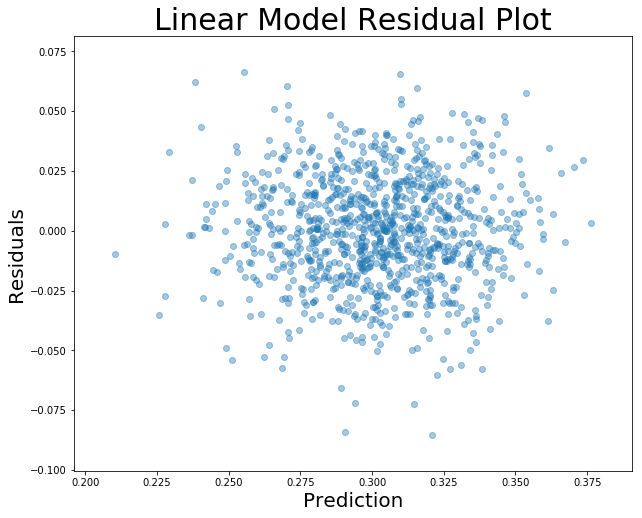

In [26]:
#our residuals are pretty randomly distributed
plt.figure(figsize=(10,8))

plt.scatter(pred, res ,alpha=.4)
plt.title("Linear Model Residual Plot",size=30)
plt.xlabel("Prediction",size=20)
plt.ylabel("Residuals",size=20)

In [14]:
#predict and score test set
pred = lm.predict(X_test)

print(f'Test R^2 = {lm.score(X_test,y_test)}')
print(f'Test MAE = {np.mean(np.abs(pred-y_test))}')
print(f'Test RMSE = {np.sqrt(np.mean((y_test - pred)**2))}')

Test R^2 = 0.53945945331237
Test MAE = 0.02013141490866667
Test RMSE = 0.02527422273817511


# Individual Players

Now let's look at the most extreme players by BABIP in 2019 and see if our model can tell us if they were doing something to earn that BABIP or if they were substantially over or under performing their peripherals

In [20]:
def predictPlayer(playerX,playery,playername):
    print(playername)
    print(f'Predicted BABIP: {lm.predict(np.array(playerX).reshape(1,-1))[0]}')
    print(f'Actual BABIP: {playery}')
    print(f'Difference: {abs(playery - lm.predict(np.array(playerX).reshape(1,-1)))[0]}')
    print(f'2 MAEs: {2*np.mean(np.abs(pred-y_test))}\n')
    playerdict = {'name': playername,'predbabip':lm.predict(np.array(playerX).reshape(1,-1))[0],
            'actbabip':playery}
    return playerdict

In [21]:
top_index = df[(df.Year == 2019)].sort_values('Babip',ascending=False).head(10).index
bottom_index = df[(df.Year == 2019)].sort_values('Babip',ascending=True).head(10).index

In [22]:
print('BABIP Overperformers\n')
for num in top_index:
    result = predictPlayer(X.iloc[num],y[num],df['Player'].iloc[num])

BABIP Overperformers

Yoán Moncada
Predicted BABIP: 0.32082957652244853
Actual BABIP: 0.406
Difference: 0.0851704234775515
2 MAEs: 0.04026282981733334

Tim Anderson
Predicted BABIP: 0.36134261606806806
Actual BABIP: 0.399
Difference: 0.037657383931931965
2 MAEs: 0.04026282981733334

Joey Gallo
Predicted BABIP: 0.3051588581386615
Actual BABIP: 0.368
Difference: 0.06284114186133849
2 MAEs: 0.04026282981733334

Brock Holt
Predicted BABIP: 0.31581822299439755
Actual BABIP: 0.365
Difference: 0.049181777005602445
2 MAEs: 0.04026282981733334

Cameron Maybin
Predicted BABIP: 0.31211593496098006
Actual BABIP: 0.365
Difference: 0.052884065039019934
2 MAEs: 0.04026282981733334

Trevor Story
Predicted BABIP: 0.33962206242175763
Actual BABIP: 0.361
Difference: 0.021377937578242356
2 MAEs: 0.04026282981733334

Aaron Judge
Predicted BABIP: 0.36448481456009507
Actual BABIP: 0.36
Difference: 0.004484814560095085
2 MAEs: 0.04026282981733334

Howie Kendrick
Predicted BABIP: 0.31756115308274435
Actual BAB

These players provide some anecdotal support for our model. In general, the hitters with extremely high BABIPs were overperforming their expected BABIPs (with the exception of Aaron Judge, who one would expect to be able to run a high BABIP given his batted ball profile). 

Several names stick out as prime candidates for regression here, in particular Yoán Mondaca, Tim Anderson, and Brock Holt. All three dramatically over performed thier expected BABIPs, and none of them are power hitters in any real sense of the word and they rely on balls in play to produce value. Given that they are unlikely to conintue such production on balls in play, it is likely that they will not continue to contribute at the levels they did in 2019.

In [23]:
print('BABIP Underperformers')
for num in bottom_index:
    predictPlayer(X.iloc[num],y[num],df['Player'].iloc[num])

BABIP Underperformers
Derek Dietrich
Predicted BABIP: 0.23811032662004003
Actual BABIP: 0.17600000000000002
Difference: 0.06211032662004001
2 MAEs: 0.04026282981733334

Jay Bruce
Predicted BABIP: 0.265802486148492
Actual BABIP: 0.2
Difference: 0.06580248614849199
2 MAEs: 0.04026282981733334

Travis Shaw
Predicted BABIP: 0.23706816096024758
Actual BABIP: 0.21600000000000005
Difference: 0.021068160960247523
2 MAEs: 0.04026282981733334

Jurickson Profar
Predicted BABIP: 0.2707071744291111
Actual BABIP: 0.218
Difference: 0.052707174429111076
2 MAEs: 0.04026282981733334

Curtis Granderson
Predicted BABIP: 0.25305338103251457
Actual BABIP: 0.22
Difference: 0.03305338103251457
2 MAEs: 0.04026282981733334

Mike Zunino
Predicted BABIP: 0.21034249250022616
Actual BABIP: 0.22
Difference: 0.009657507499773843
2 MAEs: 0.04026282981733334

Justin Smoak
Predicted BABIP: 0.26302788485086204
Actual BABIP: 0.223
Difference: 0.04002788485086203
2 MAEs: 0.04026282981733334

Yonder Alonso
Predicted BABIP: 

Not suprisingly, players that ran very low BABIPs were also very likely to be dramatically underperforming their expected BABIPs.

Most players here were bad in 2019, and this data just tells us that they were probably 'deserved' to be slightly less bad. The one compelling case is that of Derek Dietrich. He underperformed his predicted BABIP by a whopping .062, the second most in the dataset, yet somehow still ran a 102 wRC+ while only getting a hit one in every 6 times he put the ball in play. He walks and hits home runs at slightly above average clips, but he still produced pretty well despite being having exceptionally bad luck on batted balls. If there is any player worth investigating as a 2020 breakout candidate from this model, it is almost certainly Dietrich.